In [1]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [2]:
# character to index translation
vocab = set(words[0])
for i in range(len(words)):
    vocab = vocab.union(set(words[i]))
vocab = sorted(list(vocab)) 
# vocab = sorted(list(set(''.join(words))))
vocab.insert(0, '.')

In [3]:
stoi = {c:i for c, i in zip(vocab, range(len(vocab)))}
itos = {i:c for c, i in zip(vocab, range(len(vocab)))}

In [4]:
print(itos)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [5]:
# for c, i in zip(vocab, range(len(vocab))):
#     print(c, i)

In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [7]:
# block (context) size
block_size = 3

'.'*block_size + words[0]

'...emma'

In [8]:
# X = []
# Y = []

# for w in words:
#     context = '.' * block_size
#     for c in w + '.':
#         X.append([stoi[c] for c in context])
#         Y.append(stoi[c])
#         # print(context, c)
#         context = context[1:] + c
        
# X = torch.tensor(X)
# Y = torch.tensor(Y)

In [9]:
def build_dataset(words):
    X = []
    Y = []

    for w in words:
        context = '.' * block_size
        for c in w + '.':
            X.append([stoi[c] for c in context])
            Y.append(stoi[c])
            # print(context, c)
            context = context[1:] + c
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [10]:
X , Y = build_dataset(words)

torch.Size([228146, 3]) torch.Size([228146])


In [11]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [12]:
X.shape[0]

228146

In [13]:
# split the data into training, dev, testing
import random
random.seed(42)
# random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [14]:
# total_train_size = X.shape[0]
# idx = list(range(total_train_size))
# random.shuffle(idx)
# train_end_i = int(0.8 * total_train_size)
# train_idx = idx[0:train_end_i]
# Xtr, Ytr = X[train_idx], Y[train_idx]
# dev_end_i = train_end_i + int(0.1 * total_train_size)
# dev_idx = idx[train_end_i:dev_end_i]
# Xdev, Ydev = X[dev_idx], Y[dev_idx]
# # test_end_i = dev_end_i + int(0.1 * total_train_size)
# test_idx = idx[dev_end_i:]
# Xte, Yte = X[test_idx], Y[test_idx]

In [15]:
Xtr.shape, Xdev.shape, Xte.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

In [16]:
# embed dimension
dim = 10 
C = torch.randn(len(vocab), dim)

In [17]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
h = 200 # number of hidden units in the first dense layer
W1 = torch.randn((dim * block_size, h), generator=g)
# b1 = torch.zeros(h)
b1 = torch.randn(h, generator=g)
W2 = torch.randn((h, len(vocab)), generator=g)
# b2 = torch.zeros(len(vocab))
b2 = torch.randn(len(vocab), generator=g)
# W = torch.randn(dim * block_size, len(vocab))
params = [C, W1, b1, W2, b2]

In [18]:
sum(p.nelement() for p in params) # number of parameters in total

11897

In [19]:
# C[X[0]].view(-1, dim * block_size).shape

In [20]:
for p in params:
    p.requires_grad = True

In [21]:
lri = []
lossi = []
stepi = []

In [22]:
batch_size = 32

In [23]:
for i in range(200_000):
#     mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xtr_ = Xtr[ix] 
    Ytr_ = Ytr[ix]
#     forward pass

    emb = C[Xtr_].view(-1, dim * block_size)
    h1 = (emb @ W1 + b1).tanh()
    logits = h1 @ W2 + b2
    loss = F.cross_entropy(logits, Ytr_)
    
    
#     backward pass
    for p in params:
        p.grad = None
        
    loss.backward()
    
#     gradient descent
    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data +=  -lr * p.grad
    
    stepi.append(i)
    lossi.append(loss.item())

In [24]:
loss.item()

1.839640498161316

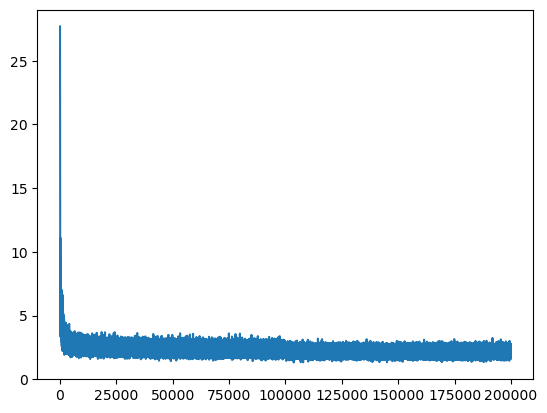

In [25]:
plt.plot(stepi, lossi)

In [26]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, dim * block_size) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1223, grad_fn=<NllLossBackward0>)

In [27]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, dim * block_size) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1600, grad_fn=<NllLossBackward0>)

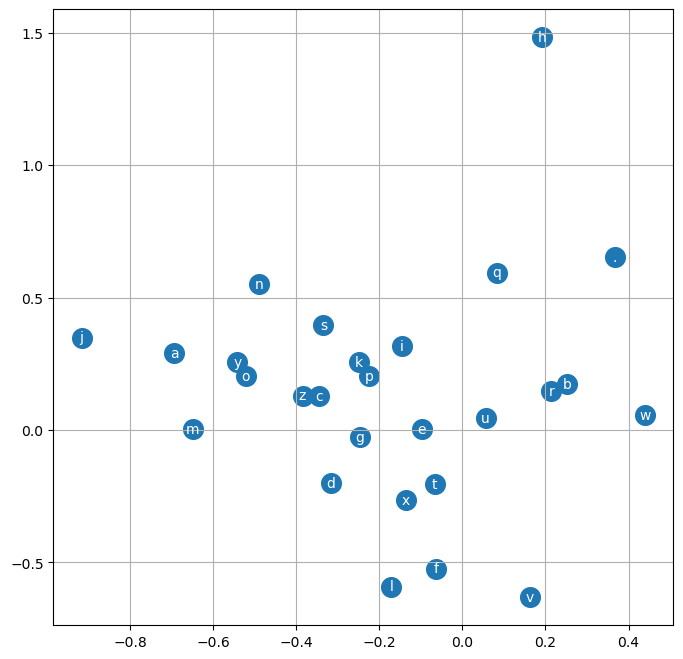

In [28]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [30]:
print(torch.__version__)

1.13.1
